In [3]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [31]:
#pip install mlxtend

In [6]:

# Load the Online Retail dataset
retail_df = pd.read_excel(r"C:\Users\ASUS\Downloads\online+retail\Online Retail.xlsx")




In [8]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [11]:
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
retail_df.shape

(541909, 8)

In [13]:
# Clean the dataset (remove null values, unnecessary columns, etc.)
retail_df = retail_df.dropna()
retail_df['Description'] = retail_df['Description'].str.strip()



C:\Users\ASUS\AppData\Local\Temp\ipykernel_12640\1199804664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['Description'] = retail_df['Description'].str.strip()


In [14]:
# Convert the dataset into a transaction format
basket = (retail_df.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))



In [15]:
# Encode the transaction data (0 for absence, 1 for presence)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)


In [29]:

# Perform association rule mining using the Apriori algorithm
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)



C:\Users\ASUS\anaconda\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [30]:
# Display the resulting association rules
print(rules)

                                           antecedents  \
0                     (72 SWEETHEART FAIRY CAKE CASES)   
1                        (60 TEATIME FAIRY CAKE CASES)   
2                     (PACK OF 60 DINOSAUR CAKE CASES)   
3                        (60 TEATIME FAIRY CAKE CASES)   
4                 (PACK OF 60 PINK PAISLEY CAKE CASES)   
..                                                 ...   
551  (ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...   
552                  (GREEN REGENCY TEACUP AND SAUCER)   
553                   (PINK REGENCY TEACUP AND SAUCER)   
554                  (ROSES REGENCY TEACUP AND SAUCER)   
555                         (REGENCY CAKESTAND 3 TIER)   

                                           consequents  antecedent support  \
0                        (60 TEATIME FAIRY CAKE CASES)            0.022578   
1                     (72 SWEETHEART FAIRY CAKE CASES)            0.029608   
2                        (60 TEATIME FAIRY CAKE CASES)            0.0

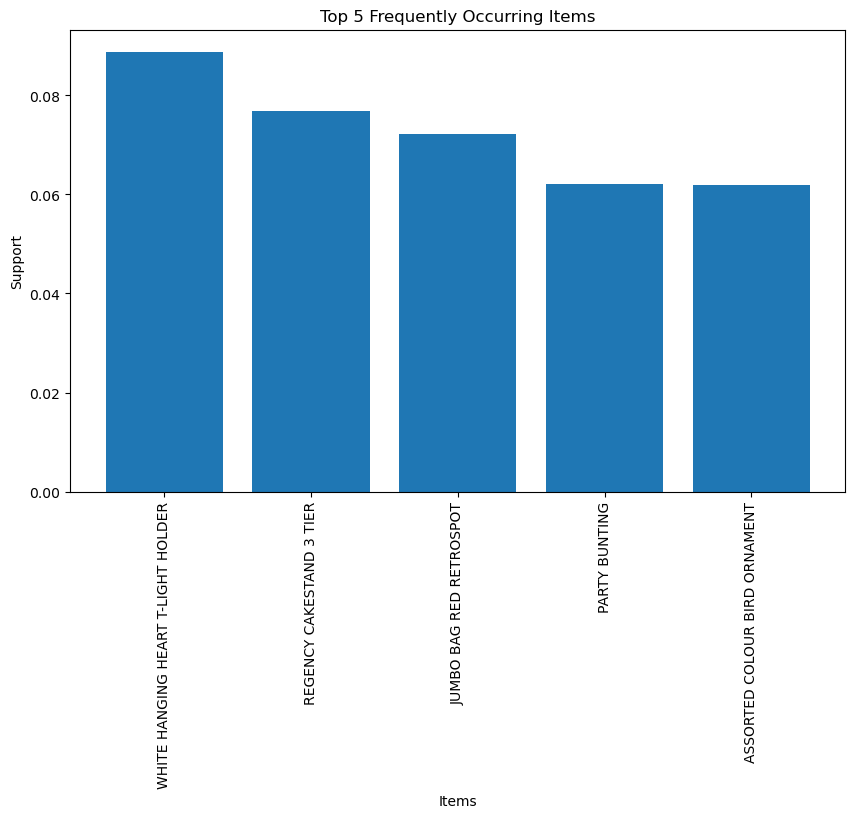

In [36]:
# visualization 
import matplotlib.pyplot as plt

# Select top N frequently occurring items
top_items = frequent_itemsets.sort_values(by='support', ascending=False).head()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_items['itemsets'].apply(lambda x: ', '.join(list(x))), top_items['support'])
plt.xticks(rotation=90)
plt.xlabel('Items')
plt.ylabel('Support')
plt.title('Top {} Frequently Occurring Items'.format(5))
plt.show()


In [48]:
#Rule evaluation Matrics

In [81]:
rules['leverage'] = (rules['support'] - rules['antecedent support'] * rules['consequent support'])/ (rules['antecedent support'] * (1 - rules['consequent support']))
rules['conviction'] = (1 - rules['consequent support']) / (1 - rules['confidence'])


In [82]:
from mlxtend.frequent_patterns import association_rules

pruned_rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
pruned_rules = pruned_rules[pruned_rules['lift'] > 1]


In [83]:
#multiple matrics comparison


In [84]:
N = 5
rules['rank'] = rules['confidence'] * rules['lift'] * rules['support']
top_rules = rules.nlargest(N, 'rank')


In [85]:
#customer segmentation 

In [86]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(basket_sets)
basket_sets['Cluster'] = cluster_labels


C:\Users\ASUS\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [87]:
#support for online recommendation

In [88]:
def recommend_items(previous_purchases, rules, top_n=5):
    recommended_items = set()
    for item in previous_purchases:
        related_items = rules[rules['antecedents'] == {item}]['consequents'].tolist()
        for items in related_items:
            recommended_items.update(items)
    recommended_items = recommended_items - set(previous_purchases)
    return list(recommended_items)[:top_n]

# Example usage
previous_purchases = ['Product1', 'Product2']
recommendations = recommend_items(previous_purchases, rules, top_n=5)
